# Online learning for motor control 

- We implement a motor control system as specified by the following block diagram 

![system](../plots/Summary/system_f.jpeg)

- We test online learning with a local learning rule: LMS with noise
- We evaluate the effect of change in learning step $\gamma$ on learning performance (learning speed and steady state error)
- Show tradeoff between learning speed and steady state error for different $\gamma$
- Examine change in tradeoff as network size changes 
  
## Method
- Train system for different $\gamma$ values same initial conditions
- Get learning speed and steady state loss
- Test for different network sizes
- Some of the simulations are performed with a julia script `testSize_static_Ls-ss_ssFromMin_simulate.jl` and analysed offline with the julia script `testSize_static_Ls-ss_ssFromMin_analyse.jl`. All the simulation data and plots are saved using DrWatson in the `plots/` and `Variables/` forlders. 
  

In [2]:
using CerebellarMotorLearning
using Distributions
using ModelingToolkit, Flux, OrdinaryDiffEq
using Plots
using Revise, Profile, PProf
using Random
using LinearAlgebra
using LaTeXStrings
using DrWatson 
using Printf

include("../scripts/sizeSim_functions.jl")

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



analysePost (generic function with 2 methods)

In [3]:
# Plots.default(titlefont = (18, "times"), legendfontsize = 16, guidefont = (16, :black), tickfont = (12, :black), grid=false, framestyle = :zerolines, yminorgrid = false, markersize=6)
Plots.default(grid=false)

## Defining parameters for the simulations

In [4]:
# indeces in the ODE system to compute errors
trainErrorIndex = 1 
onlineErrorIndex = 1
outputIndex = 3
trajErrorIndex=2;

# to save plots and values
simModel = "LMS_test"

# refernece trajecotry 
fc = 0.2; # cutoff frequency for reference signal
dtI = (2*pi)/fc*0.2 # lookahead window
ddtI = dtI/9 # lookahead time step
lookahead_times = 0.:ddtI:dtI

trajTime = 1000.; # time of the reference trajectory
trajTimePP = 1000.; 
# trajTime = 100.; # time of the reference trajectory
# trajTimePP = 100.; 

# cerebellar-like network parameters
num_nn_inputs = length(lookahead_times)
num_nn_outputs = 1;
N = 4*num_nn_inputs; 
nnDims = (num_nn_inputs,N,num_nn_outputs)
K = 4;

# for feedback controller
# Ks = (0., 0., 0., 0.);
Ks = (0.15, 0.15, 0.15, 0.);

# parameters for plant
A = [0 1 0 0; -2 -2 1 0; 0 0 0 1; 0 0 -2 -2];
B = reshape([0 ; 1 ; 0 ; 1 ],4,1);
C = reshape([1 0 0 0],1,4)
D = reshape([0],1,1)
plantMatrices = (A,B,C,D)

([0 1 0 0; -2 -2 1 0; 0 0 0 1; 0 0 -2 -2], [0; 1; 0; 1], [1 0 0 0], [0])

We first define the reference trajectory. We use a sum of sinusoidals with random frequency, phase shift and amplitude. 

The reference trajectories $r(t)$ are a sum of $4$ sinusoids with random frequencies, phase shifts and amplitudes.
\begin{equation}
    r(t) = \frac{1}{4}\sum_{i=1}^4 A_i \sin(\omega_i t+\phi_i)
\end{equation}
$\omega_i$ is drawn from a random uniform distribution in the interval $[\omega_c/5,\omega_c]$, $\omega_c$ being the cut-off frequency. We set $\omega_c=0.5Hz$. The phase shifts $\phi_i$ are drawn from a random uniform distribution in the interval $[0,\pi/2]$ and the amplitudes $A_i$ from a random uniform distribution in $[0.1,4]$.
All tracking problems must be band limited to take into account the limits of the plant dynamics. This cut-off frequency ensures that the plant is able to produce the reference trajectory. 

The following command will take some time (some minutes) to run the first time as it compiles the build_system function (including building the whole ODE system). The following times the function is called, it should be much faster.

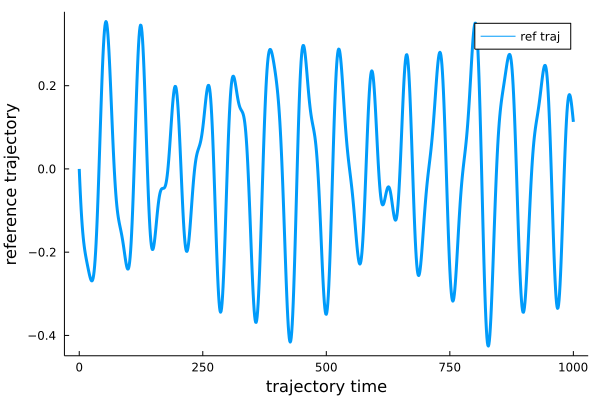

In [5]:
refF = sinFunDef(fc) # reference trajectory function is sum of sins
system = build_system(plantMatrices,Ks,nnDims,K,refF,trajTime,lookahead_times);
plot(0:trajTime,refF.(0:trajTime),lw=3,xlabel="trajectory time", ylabel="reference trajectory",label="ref traj")

## Training with a local learning rule

<!-- Define the training parameters. We update the weights every $\delta t=1.0$ according to a local online learning rule. We use an adapted form of the Least Mean Squares (LMS). -->

<!-- The exact mechanisms leading to synaptic plasticity have been investigated in depth both experimentally and theoretically \cite{Kawato2009, Kawato2020, Raymond2018}.  -->
The cerebellar network learns by varying the output weights $\mathbf{w}(t)$ during the movement to improve the inverse model while controlling the movement.
For modeling simplicity, we assume the weights are updated at a regular interval $\delta t_e=1$. 

$\mathbf{w}(t)$ is modified when the purkinje cell inputs $\mathbf{h}(t)$ and climbing fibre signal $e(t)$ are activated coincidentally over a narrow interval 50-200ms.
<!-- \cite{Suvrathan2016}.  -->

We model learning with a simplified learning rule inspired by the classic Widrow-Hoff or Least-Mean-Square (LMS) rule. 
<!-- \cite{Widrow1960,Fujita1982,Kawato1987,Kawato1992}. -->
The change in weights $\delta \mathbf{w}$ at some time $t$ during the trajectory is given   
$$
    \delta \mathbf{w} = -\gamma e(t) \mathbf{h}(t-\Delta t_h) + \eta \hat{\epsilon}
$$
where $\hat{\cdot}$ denotes a normalised vector, $0<\gamma \ll 1$ is the learning step, $\Delta t_h$ is the delay between purkinje cell input and climbing fibre signal that leads to synaptic plasticity. $\eta\hat{\epsilon}$ is the learning noise which captures imperfections in the synaptic plasticity mechanism and in the error information available. 
We model $\epsilon$ as a vector with each component drawn from a normal distribution. 

The ratio $\frac{\gamma}{\eta}$ is constant; if the LMS related synaptic plasticity increases we expect the strength of the learning noise to also increase. $e(t)$ is the climbing fibre activity given by 
$$
    e(t) = \frac{1}{\Delta t_e-\Delta t_r}\int^{t-\Delta t_r}_{t-\Delta t_e} y(t',\mathbf{w})-r(t')dt'
$$
this error indicates the difference between the reference and actual trajectory over a small window of time in the past given by $[t-\Delta t_e,t-\Delta t_r]$, where $\Delta t_e$ is the online learning time window, and $\Delta t_r$ is the delay time.  $\Delta t_e$ is determined by how much memory of the error the motor system has access to and $\Delta t_r$ is determined by reaction times, and delays in the error signals carried by the climbing fibres to the cerebellar cortex.
<!-- \cite{Suvrathan2016,Menghini2013,Stoodley2012}.  -->
<!-- Learning rules similar to this one have been studied including its convergence \cite{Fujita2022}.  -->

<!-- The basic assumption for cerebellar cortex network is that the climbing fibre activity encodes the error $r(t)-y(t)$ and that LTD and LTP can realise the LMS rule. 

The classic LMS rule is given by $\delta \mathbf{w} = -\gamma \mathbf{h}(t)(r(t)-y(t))$. 
The main differences between our model and classic LMS are 
    - In classic LMS the weight update is continuous, in our case, the weights are updated at discrete points in time during the trajectory. 
    - We assume the climbing fibre activity can encode an error with some memory given in the time window $[t-\Delta t_e, t-\Delta t_r]$. $\Delta t_r$ denotes the delay between the trajectory is executed and the climbing fibre signal arrives to the cerebellar network. 
    - We introduce a possible delay between the granule cell activity and the climbing fibre activity leading to synaptic plasticity. This delay is represented by $\Delta t_h$. 
    -  We include learning noise arising from imperfections in the synaptic plasticity mechanisms or in the information on the error $e(t)$. 
 -->




In [6]:
dt = 1.0
t_train = 0.01:dt:trajTime # train times (callbacks doesn   't stop at t=0.0)

deltaTe = 1.0
deltaTr = 0.5
deltaTh = 0.1

SNR = 2
gamma = 0.01
eta = gamma/SNR


a = LMSTrain(gamma,t_train,deltaTe,deltaTr,deltaTh,trajErrorIndex,0.0);
b = GaussianNoise(eta,t_train);
updates = [a,b];


# Post process
saveEpochsInt = 1;
t_save = t_train
records = [LearningPerformanceTask(t_save,trainErrorIndex)]


1-element Vector{LearningPerformanceTask{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, Int64}}:
 LearningPerformanceTask{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, Int64}(0.01:1.0:999.01, 1)

Next we do the training over a single trajectory, with the local online learning rule. We store the weights during training. 

In [7]:
trainStore = train(system,updates,trajTime);

We plot the reference trajectory and the actual trajectory (plant output). 

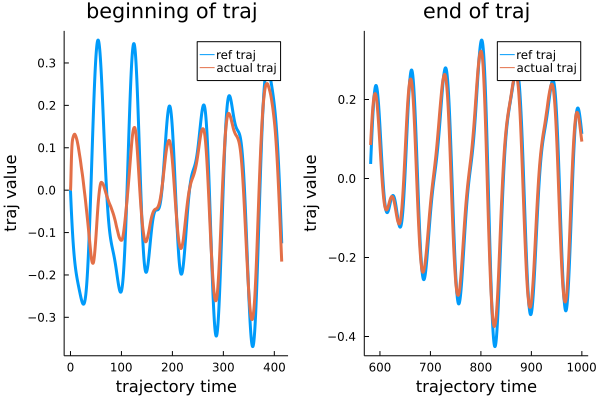

In [8]:
i = 50*100

p1 = plot(trainStore[:t][1:i],trainStore[:refTraj][1:i],lw=3,legend=false)
plot!(trainStore[:t][1:i],trainStore[:plantOutput][1:i],lw=3)
plot!(xlabel="trajectory time",ylabel="traj value",title="beginning of traj")

p2 = plot(trainStore[:t][end-i:end],trainStore[:refTraj][end-i:end],lw=3,label="ref traj")
plot!(trainStore[:t][end-i:end],trainStore[:plantOutput][end-i:end],lw=3,label="actual traj")
plot!(xlabel="trajectory time",title="end of traj")

plot(p1,p2,layout = (1,2))

As the NN is randomly initialised, at the beginning of the trajectory the NN, the actual traj doesn't track fully well the reference trajectory. During the trajecoty the system is learning: the NN otuput improves the motor command sent to the plant. By the end, the two trajectories are close to each other. 

Note that at the beginning of the trajectory, the feedback controller (FB) maintains the plant output stable and controls in a approximate way the plant. By the end of the trajectory, the NN (feedforward controller) takes over, and the load of the FB controller is smaller. 

We can plot the output weights of the NN during the trajectory. We expect some change during the trajectory as the system is learning. 

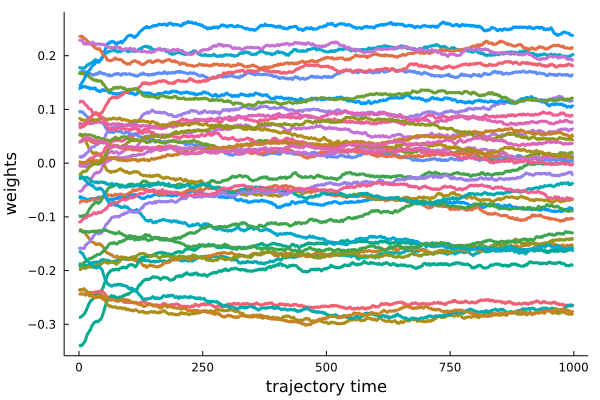

In [9]:
plot(t_train,trainStore[:weights][:,:]',lw=3,legend=false)
plot!(xlabel="trajectory time",ylabel="weights")

Changes of the cerebellar output weights $\mathbf{w}(t)$ lead to better trajectory performance. 
The perfect cerebellar output weights would lead to matched $y(t)$ and $r(t)$ over the entire movement. 
We define the **task loss** as the difference between the reference and actual trajectory over the whole movement if the weights were fixed to $\mathbf{w}$ 
$$
    L[\mathbf{w}] = \frac{1}{2T}\int_{t=0}^T ||y(t;\mathbf{w})-r(t)||_2^2 dt
$$
The task loss quantifies how well the cerebellum has learned to control the plant, it only depends on the cerebellar output weights. 
Throughout learning, as the output weights change, we can calculate the task loss. 
As the system is learning online, during the movement, it doesn't have access to the task loss to learn. 
Hence, the task loss will not be monotonically decreasing over the whole learning period. However, overall, as the system is learning, the task loss decreases over the whole movement.

In [10]:
postStore = postProcess(system,trainStore,t_save,records,trajTimePP)

Dict{Symbol, Any} with 4 entries:
  :steadyStateE  => 0.000810839
  :learningSpeed => 0.0229292
  :fitParams     => [0.0658373, 0.0229292, 0.000810839]
  :taskError     => [0.0598859 0.0598425 … 0.000561171 0.000556328]

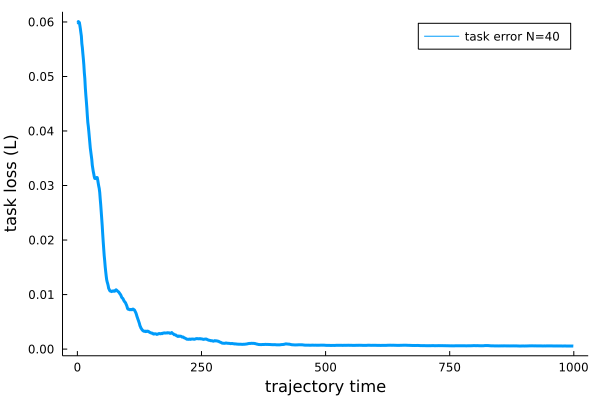

In [11]:
plot(t_save,postStore[:taskError]',lw=3,label=string("task loss N=",N))
plot!(xlabel="trajectory time",ylabel="task loss (L)")

In the context of motor learning there are two measures that are important to quantify learning performance: **learning speed** and **steady state loss**. 
The first one quantifies how fast the system can learn to control the plant when the error is relatively large. Steady state loss quantifies the accuracy of learning, how close the reference and actual trajectory can get when learning reaches a pseudo steady state.  

## The effect of the learning step on learning performance 
There is a general trade-off between the steady state loss and the learning speed determined by the sensitivity to error information (the learning step $\gamma$). A large learning step, means the system is very sensitive to new information and can learn fast but cannot achieve good steady state performance.
On the other hand, a small learning step $\gamma$ leads to a slow learning speed but better steady state performance. Increasing the learning step can increase the learning speed but at the expense of decreasing steady state performance.

To illustrate this we can train the same system with a different $\gamma$. 

In [12]:
gamma2 = 0.07
eta2 = gamma2/SNR

a2 = LMSTrain(gamma2,t_train,deltaTe,deltaTr,deltaTh,trajErrorIndex,0.0);
b2 = GaussianNoise(eta2,t_train);
updates2 = [a2,b2];

In [13]:
trainStore2 = train(system,updates2,trajTime);

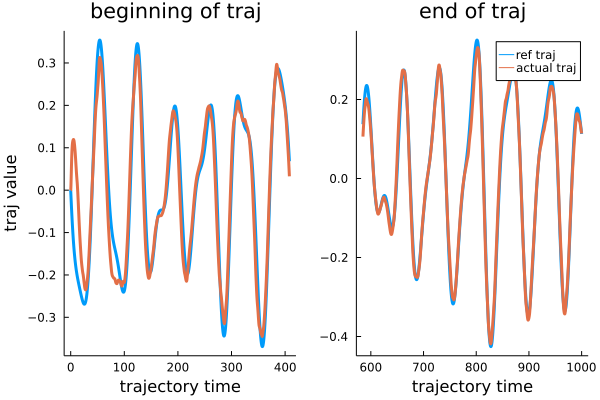

In [24]:
p1 = plot(trainStore2[:t][1:i],trainStore2[:refTraj][1:i],lw=3,legend=false)
plot!(trainStore2[:t][1:i],trainStore2[:plantOutput][1:i],lw=3)
plot!(xlabel="trajectory time",ylabel="traj value",title="beginning of traj ")

p2 = plot(trainStore2[:t][end-i:end],trainStore2[:refTraj][end-i:end],lw=3,label="ref traj")
plot!(trainStore2[:t][end-i:end],trainStore2[:plantOutput][end-i:end],lw=3,label="actual traj")
plot!(xlabel="trajectory time",title="end of traj")

plot(p1,p2,layout = (1,2))

In [15]:
postStore2 = postProcess(system,trainStore2,t_save,records,trajTimePP)

Dict{Symbol, Any} with 4 entries:
  :steadyStateE  => 0.000483847
  :learningSpeed => 0.0968788
  :fitParams     => [0.0747572, 0.0968788, 0.000483847]
  :taskError     => [0.0598859 0.0619016 … 0.000256897 0.000130004]

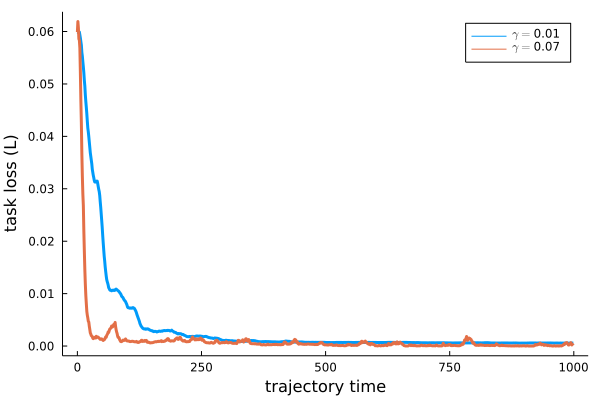

In [16]:
plot(t_save,postStore[:taskError]',lw=3,label=string(L"\gamma=",gamma))
plot!(t_save,postStore2[:taskError]',lw=3,label=string(L"\gamma=",gamma2))
plot!(xlabel="trajectory time",ylabel="task loss (L)")

We observe that for larger $\gamma$ the task loss decreases faster, it can achieve larger learning speed. To compute the steady state loss we must train for a longer trajectory time to assure that the system has reached steady state. 

We run simulations as described above, with longer trajecotry times to compute the steady state loss and for a wider range of learnign steps $\gamma$. 

Due to longer computation time, we do this simulations in from the julia scripts (see `testSize_static_Ls-ss_ssFromMin_simulate.jl`). In this notebook we can load the saved results using DrWatson. 

In [17]:
using DataFrames

simModel = "LMS_size_test_seed9"
path = string(simModel,"_",10,"_",90)

# dfLsSS has a columns named :postStores, mu, Ns,seed
dfLsSS = collect_results(datadir("simulations",path);verbose=false) # get data in the path with simulations
sort!(dfLsSS,:seed)

## Select poststores and trainstores according to seed and mus
seeds = unique(dfLsSS[!,:seed])

mus = unique(dfLsSS[!,:mu])[1]
Ns = unique(dfLsSS[!,:Ns])[1] # get net sizes

# get postStores an array of arrays size length(seeds)xlength(Ns)xlength(mus)
postStores = map(seeds) do s # get postStore for each net size for a given seed
    filter(row -> (row.seed==s),dfLsSS)[:,:postStores][1]
end
postStoresSS = map(seeds) do s # get postStore for each net size for a given seed
    filter(row -> (row.seed==s),dfLsSS)[:,:postStoresSS][1]
end
loop_3(postStoresSS,computeDynamicSS!,[100,false]) # compute dynamic ss

t_save2 = dfLsSS[!,:t_save][1]

loop_3(postStores,computeDynamicLs!,[t_save2,50]) # compute dynamic ls 
loop_3(postStores,computeDynamicSS!,[50]); # compute dynamic ss

lsAllD = loop_3(postStores,getValF,[:dynamicLs,mean]);
ssAll = loop_3(postStoresSS,getValF,[:steadyStateE,mean]);

println("loaded")

┌ Info: Scanning folder /Users/adrianaperezrotondo/Dropbox (Cambridge University)/ControlLab/Projects/CerebellumExpansion/Code/Julia/CerebellarMotorLearning/data/simulations/LMS_size_test_seed9_10_90 for result files.
└ @ DrWatson /Users/adrianaperezrotondo/.julia/packages/DrWatson/S4dYA/src/result_collection.jl:115


loaded


We can now plot the steady state loss vs the learning speed for the same system trained with different $\gamma$ values.

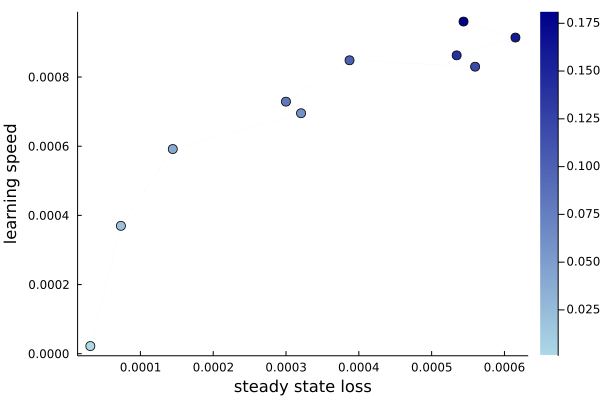

In [18]:
Nind = 1
simI = 1

plot(ssAll[simI][Nind],lsAllD[simI][Nind],fill_z=mus[Nind],markershape=:circle,markersize=5,marker_z=mus[Nind],lw=0,color=:blues,label=false)
plot!(xlabel="steady state loss", ylabel="learning speed")

In the figure above, the color of each point indicates the value of $\gamma$. We observe that as the learning step increases the learning speed as well but so does the steady state loss. This indicates that larger sensitivity to new information (larger $\gamma$) can help learn faster but to lower precision. 

## The effect of the NN input expansion on learning performance
<!-- 
Next we explore the effect of the size of the NN on learning performance. 
We add hidden layer units (granule cells) to the NN and evaluate the learning speed and steady state loss.  -->

One of the main characteristics of the cerebellar cortex architecture is the large input expansion from the mossy fibres to the granule cell layer. 
The mossy fibre signals, encoding the desired movement, are transformed by the large non-linear granule cell layer to the purkinje cell signal. It has been shown that such a network can approximate any input-output function as long as it has a large enough granule cell layer.
<!-- \cite{Cybenko1989, Funahashi1989, Hornik1989}.    -->

We investigate how the size of the input expansion affects online learning performance in the context of motor control.

We performed a network expansion in the cerebellar network increasing the number of granule cells from $N$ to $\tilde{N}$ while keeping the number of mossy fibres $I$ constant. We define $q \equiv \frac{I}{N}$ as the input expansion ratio. 

Each new granule cell forms input connections with $K=4$ randomly chosen input mossy fibres. Hence the input weight matrix of the expanded network $\tilde{Z}\in \mathbb{R}^{I\times \tilde{N}}$ is composed of the initial weights matrix $Z$ and added columns each with $K$ non-zero elements.

The expanded system has the same reference trajectory, plant and feedback controller.

In [19]:
N2 = 2*N # size of the expanded NN

Z0 = system.nn.Z # input weights of the small NN
W0 = system.nn.W # output weights of the small NN
plant = system.plant
pid = system.pid
ref = system.ref
paramsN = [plant,pid,nnDims,ref,trajTime,lookahead_times,Z0,W0];
system2 = build_system_N(paramsN,N2,K); # expanded NN
println("system 2 built")

system 2 built


In [20]:
trainStore1L = train(system2,updates,trajTime);
postStore1L = postProcess(system2,trainStore1L,t_save,records,trajTimePP);

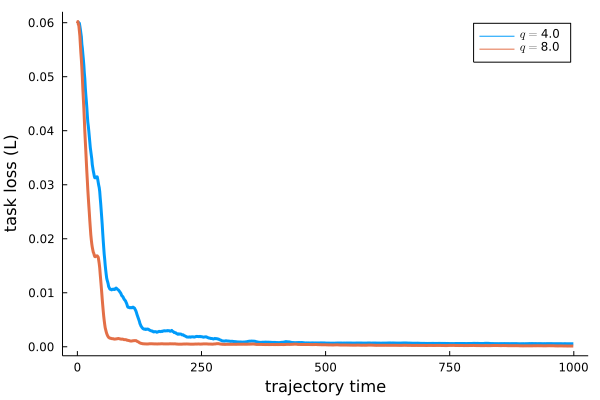

In [21]:
plot(t_save,postStore[:taskError]',lw=3,label=string(L"q=",N/10))
plot!(t_save,postStore1L[:taskError]',lw=3,label=string(L"q=",N2/10))
plot!(xlabel="trajectory time",ylabel="task loss (L)")

The larger network can learn faster and to better precision (larger learning speed and smaller steady state loss). 
We formalise this result by evaluating the learning speed and steady state loss for different sized networks and for different $\gamma$. 

We perform 15 simulations with different initialisations of reference trajectories and network weights. We average the learning speed and steady state loss over the different simulations. 
As the simulations are computationally expensive, we perform these simulations with a script. 

We found that the learning speed increases as we increase the number of granule cells and the steady state loss decreases. This benefit in learning performance saturates as the granule cell layer expansion keeps increasing. 

![trade-off](../plots/Summary/lsOpt.jpeg)

![trade-off](../plots/Summary/ss_atOptls.jpeg)

We can plot as above the steady state loss vs the learning speed for different learning steps $\gamma$. We repeat the process for different input expansion ratios $q$ (the ratio between the number of inputs to the NN and the hidden layer units). 

![trade-off](../plots/Summary/ssVsLS_LMS-gaussian.jpeg)


Each color (blue, orange, green) denotes a different expansion ratio. The opacity denotes the learning step $\gamma$. Lighter to darker denotes increasing $\gamma$. 

We observe that for each different $q$, there is a trade-off between the learning speed and steady state loss as $\gamma$ changes. However, the granule cell layer expansion navigates this trade-off. 
The systems with larger input expansion can achieve simultaneously better learning speed and steady state performance. 

## Training with different learning rules 

We can easily train the system with a different learning rule. For example, gradient descent on the task loss $L$. At each weight update time point $t$, we can compute the task loss and the gradient with respect to the weights $\mathbf{w}$ and update the weights using gradient descent:

$$\delta \mathbf{w}(t) = -\gamma \nabla_{w} L[\mathbf{w}(t)]$$

In [22]:
uGD = [GradientTrain(gamma,t_train,trainErrorIndex,trajTime)];

In [23]:
trainStoreGD = train(system,uGD,trajTime);
postStoreGD = postProcess(system,trainStoreGD,t_save,records,trajTimePP);

We plot the task loss during training with gradient descent and, for comparison, with the online learning rule described above. 

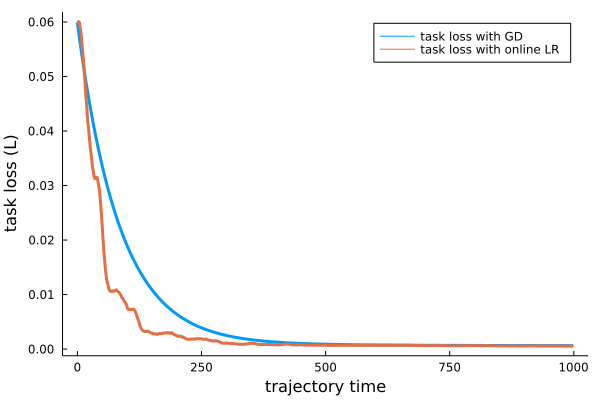

In [26]:
plot(t_save,postStoreGD[:taskError]',lw=3,label=string("task loss with GD"))
plot!(t_save,postStore[:taskError]',lw=3,label=string("task loss with online LR"))
plot!(xlabel="trajectory time",ylabel="task loss (L)")

We observe that the task loss form gradient descent training decreases monotonuously (due to the abscence of noise). 

In this case, in both of the training scenarios (gradient descent and online learning) the same learning step $\gamma$ was used. 
We observe the gradient descent case has smaller learning speed, however, we expect that we can find a learning step $\gamma$ for which, the learning speed with gradient descent is larger than with online learning with noise. 